In [13]:
from IPython.display import HTML, display

bmw_m3_url = "https://i.ytimg.com/vi/_HJXb_i4nxU/maxresdefault.jpg"
bm2_m5_url = "https://s.yimg.com/ny/api/res/1.2/K.4rgz5llYrJS6OGONrjpA--/YXBwaWQ9aGlnaGxhbmRlcjt3PTEyNDI7aD02OTk-/https://media.zenfs.com/en/the_drive_634/08a009aa430b59590ddeec0e177b49be"
html = f"""
<div style="display:flex; justify-content:center; gap:40px;">
  <div style="text-align:center;">
    <img src="{bmw_m3_url}" style="width:520px; height:260px; object-fit:cover;"><br>
    <b>M3 2025</b>
  </div>
<div style="display:flex; justify-content:center; gap:40px;">
  <div style="text-align:center;">
    <img src="{bm2_m5_url}" style="width:520px; height:260px; object-fit:cover;"><br>
    <b>M5 2025</b>
  </div>
  """
display(HTML(html))

In [12]:
import pandas as pd

bmw = pd.read_csv('bmw_dataset.csv')


print("DataFrame Head:")
print(bmw.head())
print("\nDataFrame Info:")
bmw.info()



DataFrame Head:
      Model  Year         Region  Color Fuel_Type Transmission  Engine_Size_L  \
0  5 Series  2016           Asia    Red    Petrol       Manual            3.5   
1        i8  2013  North America    Red    Hybrid    Automatic            1.6   
2  5 Series  2022  North America   Blue    Petrol    Automatic            4.5   
3        X3  2024    Middle East   Blue    Petrol    Automatic            1.7   
4  7 Series  2020  South America  Black    Diesel       Manual            2.1   

   Mileage_KM  Price_USD  Sales_Volume  ... Cluster_DBSCAN  Cluster_Agglo  \
0      151748      98740          8300  ...              0              0   
1      121671      79219          3428  ...              0              0   
2       10991     113265          6994  ...              0              0   
3       27255      60971          4047  ...              0              1   
4      122131      49898          3080  ...              0              1   

   Anomaly_IF  Anomaly_LOF  Sales_

In [4]:
print("\nDescriptive Statistics:")
print(bmw.describe())


Descriptive Statistics:
               Year  Engine_Size_L     Mileage_KM      Price_USD  \
count  50000.000000   50000.000000   50000.000000   50000.000000   
mean    2017.015700       3.247180  100307.203140   75034.600900   
std        4.324459       1.009078   57941.509344   25998.248882   
min     2010.000000       1.500000       3.000000   30000.000000   
25%     2013.000000       2.400000   50178.000000   52434.750000   
50%     2017.000000       3.200000  100388.500000   75011.500000   
75%     2021.000000       4.100000  150630.250000   97628.250000   
max     2024.000000       5.000000  199996.000000  119998.000000   

       Sales_Volume  Elasticity_Index  Revenue_Density  \
count  50000.000000      4.166600e+04     5.000000e+04   
mean    5067.514680      4.092792e-18     3.802449e+08   
std     2856.767125      1.000012e+00     2.623406e+08   
min      100.000000     -8.898126e+01     3.410472e+06   
25%     2588.000000     -1.189572e-02     1.689871e+08   
50%     5087.0

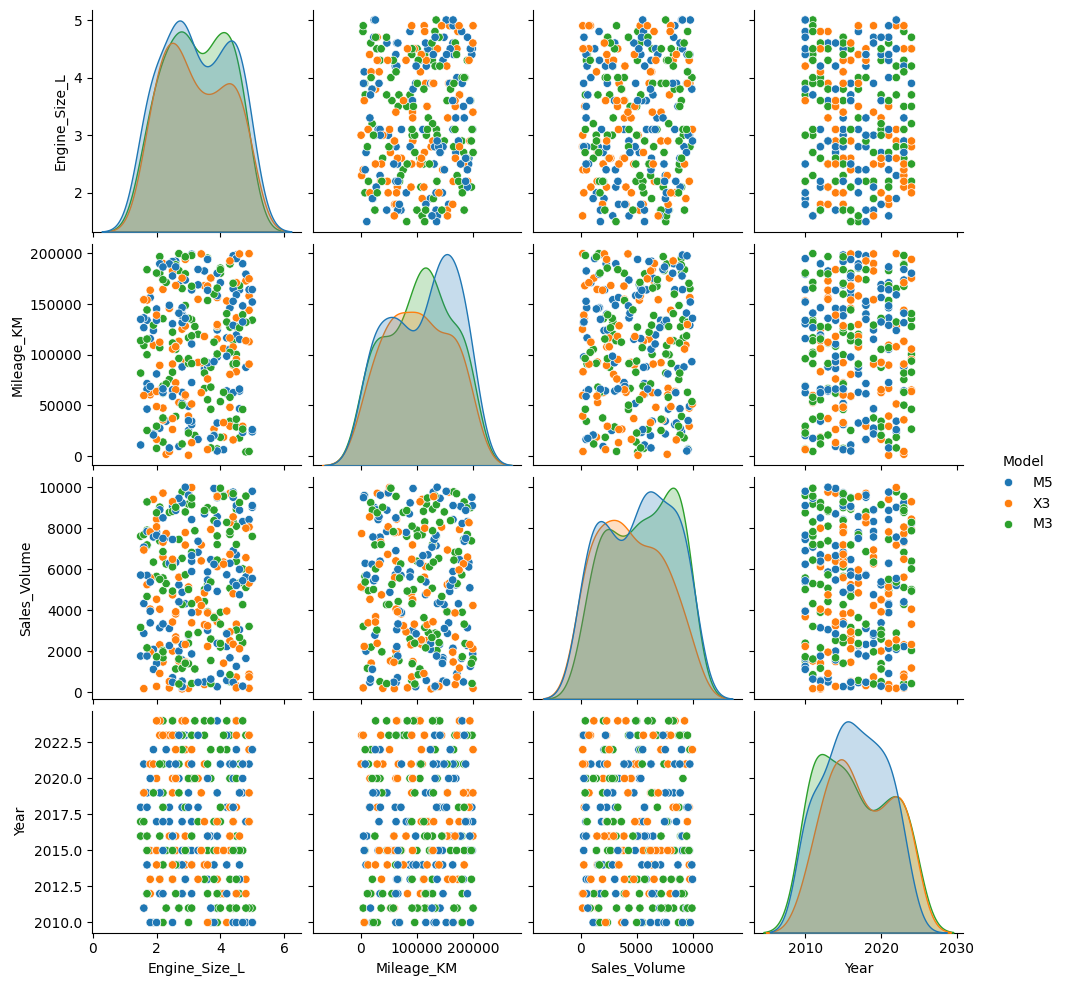

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

modelos_filtrados = ['M5', 'M3','X3']

bmw_filtrado = bmw[bmw['Model'].isin(modelos_filtrados)]

bmw_sample = bmw_filtrado.sample(300)

sns.pairplot(bmw_sample,
             vars = ['Engine_Size_L','Mileage_KM','Sales_Volume','Year'],
             hue='Model',
             diag_kind='kde')

plt.show()

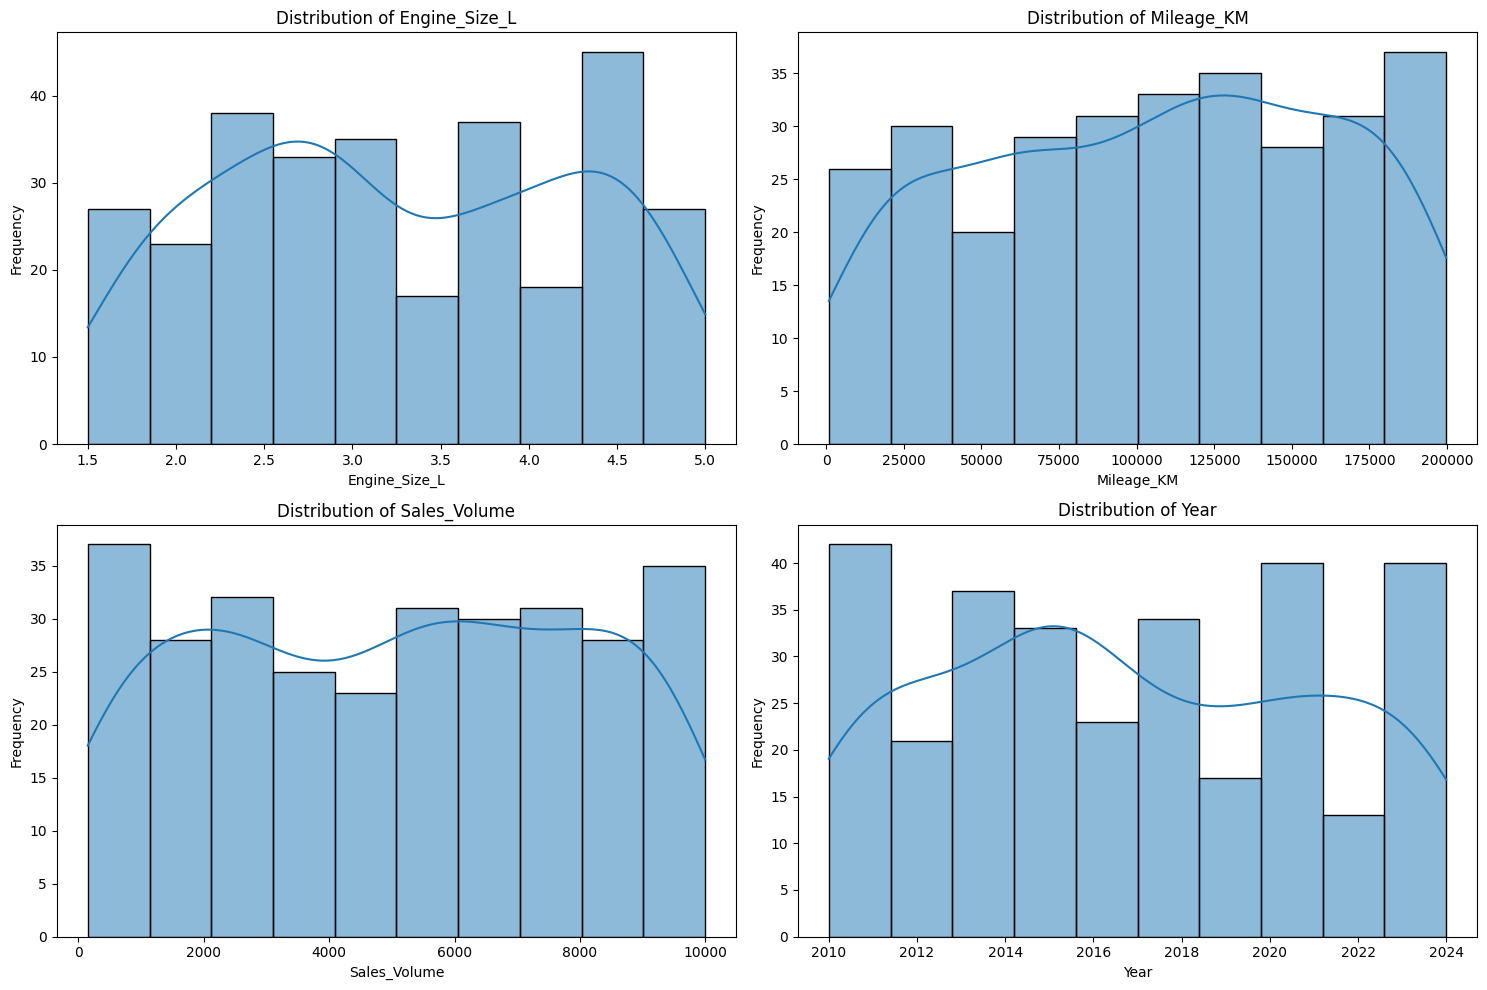

In [21]:
numerical_vars = ['Engine_Size_L', 'Mileage_KM', 'Sales_Volume','Year']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_vars):
    plt.subplot(2, 2, i + 1) # Arrange plots in a 2x2 grid
    sns.histplot(bmw_sample[col], kde=True) # Use histplot for distribution
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

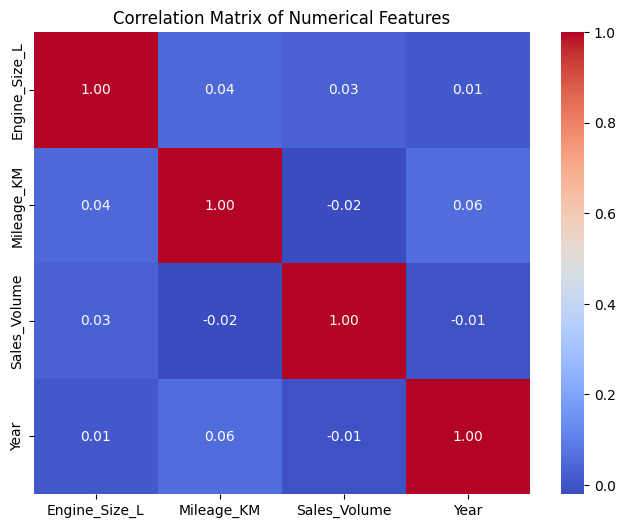

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(bmw_sample[numerical_vars].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

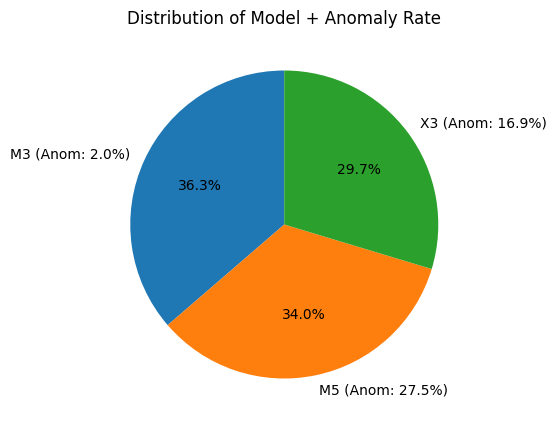

In [24]:
plt.figure(figsize=(5, 5))

anom_rate = bmw_sample.groupby('Model')['Anomaly_IF'] \
                       .apply(lambda x: (x == -1).mean())

labels = [f"{model} (Anom: {anom_rate[model]*100:.1f}%)"
          for model in anom_rate.index]

plt.pie(bmw_sample['Model'].value_counts(),
        labels=labels,
        autopct='%1.1f%%',
        startangle=90)

plt.title('Distribution of Model + Anomaly Rate')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = bmw_sample[['Engine_Size_L', 'Mileage_KM', 'Sales_Volume']]
y = bmw_sample['Anomaly_IF']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42,
                                                    stratify=y,
                                                    shuffle=True)

print("Data splitting complete.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("\nApplying StandardScaler to training data...")

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

print("Scaling of training data complete.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")

Data splitting complete.
X_train shape: (240, 3)
X_test shape: (60, 3)
y_train shape: (240,)
y_test shape: (60,)

Applying StandardScaler to training data...
Scaling of training data complete.
X_train_scaled shape: (240, 3)


In [16]:
type(X_train_scaled), type(y_train)

(numpy.ndarray, pandas.core.series.Series)

In [17]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

print("Starting Nested Cross-Validation with scaled data...")

# 3. Define the parameter grid for K-Nearest Neighbors (KNN)
knn_param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9]
}

# 4. Define the parameter grid for Gaussian Naive Bayes (NB)
nb_param_grid = {
    'var_smoothing': np.logspace(start=0, stop=-9, num=100, base=10)  #1,0.79...,0.63...,...,10−9
}                               #base**start,  base**stop

# 5. Initialize an outer_cv object using StratifiedKFold
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 6. Initialize empty lists to store the cross-validation scores for KNN and Naive Bayes
knn_outer_scores_scaled = []
nb_outer_scores_scaled = []

# 7. Loop through the outer folds of the scaled training data
for train_idx, test_idx in outer_cv.split(X_train_scaled, y_train):
    X_outer_train_scaled, X_outer_test_scaled = X_train_scaled[train_idx], X_train_scaled[test_idx]
    y_outer_train, y_outer_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # a. Inside the loop, define an inner_cv object
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # b. For KNN:
    # i. Create a GridSearchCV object
    knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=inner_cv, scoring='accuracy')
    # ii. Fit the GridSearchCV object on the outer training fold
    knn_grid_search.fit(X_outer_train_scaled, y_outer_train)
    # iii. Evaluate the best_estimator_ on the outer test fold
    knn_best_model = knn_grid_search.best_estimator_
    knn_pred = knn_best_model.predict(X_outer_test_scaled)
    knn_outer_scores_scaled.append(accuracy_score(y_outer_test, knn_pred))

    # c. For Naive Bayes:
    # i. Create a GridSearchCV object
    nb_grid_search = GridSearchCV(GaussianNB(), nb_param_grid, cv=inner_cv, scoring='accuracy')
    # ii. Fit the GridSearchCV object on the outer training fold
    nb_grid_search.fit(X_outer_train_scaled, y_outer_train)
    # iii. Evaluate the best_estimator_ on the outer test fold
    nb_best_model = nb_grid_search.best_estimator_
    nb_pred = nb_best_model.predict(X_outer_test_scaled)
    nb_outer_scores_scaled.append(accuracy_score(y_outer_test, nb_pred))

# 8. Print the mean and standard deviation of the cross-validation scores
print("\nNested Cross-Validation Results with Scaled Data:")
print(f"KNN - Mean Accuracy: {np.mean(knn_outer_scores_scaled):.4f} (+/- {np.std(knn_outer_scores_scaled):.4f})")
print(f"Naive Bayes - Mean Accuracy: {np.mean(nb_outer_scores_scaled):.4f} (+/- {np.std(nb_outer_scores_scaled):.4f})")

Starting Nested Cross-Validation with scaled data...

Nested Cross-Validation Results with Scaled Data:
KNN - Mean Accuracy: 0.8667 (+/- 0.0102)
Naive Bayes - Mean Accuracy: 0.8667 (+/- 0.0102)
